In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import networkx as nx
import plotly.graph_objects as go
import plotly.offline as pyo
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
import shap
from urllib.request import urlretrieve

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [71]:
candidate = pd.read_csv("../Data/candidates_ge15.csv")
candidate.fillna(candidate.age.mean(), inplace=True)
census = pd.read_csv("../Data/census_parlimen.csv")
census.fillna(census.sme_small.mean(), inplace=True)
# results = pd.read_csv("../Data/results_parlimen_ge15.csv")

In [88]:
merged_df = candidate.merge(census, on=["state", "parlimen"], how="left")
# merged_df = merged_df.merge(results, on=["state", "parlimen"], how="left")

In [89]:
# Dropping votes, result_desc, and new_mp
merged_df = merged_df.drop(
    [
        "state","name","parlimen",
        "name_display",
        "votes",
        "result_desc",
        "new_mp",
        "code_state",
        "code_parlimen",
        "year"
    ],
    axis=1,
)

In [90]:
ethnicity_mapping = {"bumiputera": 1, "chinese": 2, "indian": 3, "other": 4}
party_mapping = {
    party: index + 1 for index, party in enumerate(merged_df["party"].unique().tolist())
}

In [91]:
target_column = "result"

merged_df["sex"] = merged_df["sex"].apply(lambda x: 1 if x == "male" else 0)
merged_df["ethnicity"] = merged_df["ethnicity"].map(ethnicity_mapping)
merged_df["party"] = merged_df["party"].map(party_mapping)

label_encoder = LabelEncoder()
categorical_columns = merged_df.select_dtypes(include=["object"]).columns
for column in categorical_columns:
    merged_df[column] = label_encoder.fit_transform(merged_df[column])

# Define features (X) and target (y)
X = merged_df.drop(target_column, axis=1)
y = merged_df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy}\n")
print(classification_rep)

Accuracy: 0.721830985915493

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       219
           1       0.15      0.05      0.07        65

    accuracy                           0.72       284
   macro avg       0.46      0.48      0.45       284
weighted avg       0.62      0.72      0.66       284



['ballot_order',
 'age',
 'sex',
 'ethnicity',
 'party',
 'area_km2',
 'population_total',
 'nationality_citizen',
 'nationality_non_citizen',
 'sex_male',
 'sex_female',
 'ethnicity_proportion_bumi',
 'ethnicity_proportion_chinese',
 'ethnicity_proportion_indian',
 'ethnicity_proportion_other',
 'age_proportion_0_14',
 'age_proportion_15_64',
 'age_proportion_65_above',
 'age_proportion_18_above',
 'housing_total',
 'household_total',
 'household_size_avg',
 'live_births',
 'live_births_male',
 'live_births_female',
 'deaths',
 'deaths_male',
 'deaths_female',
 'labour_participation_rate',
 'labour_unemployment_rate',
 'income_median',
 'income_avg',
 'expenditure_avg',
 'gini',
 'poverty_incidence',
 'sme_small',
 'sme_micro',
 'sme_medium',
 'businesses_agriculture',
 'businesses_crops',
 'businesses_livestock',
 'businesses_fisheries',
 'businesses_forestry',
 'businesses_mining',
 'businesses_manufacturing',
 'businesses_construction',
 'businesses_services',
 'utilities_pipedwate

In [86]:
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)


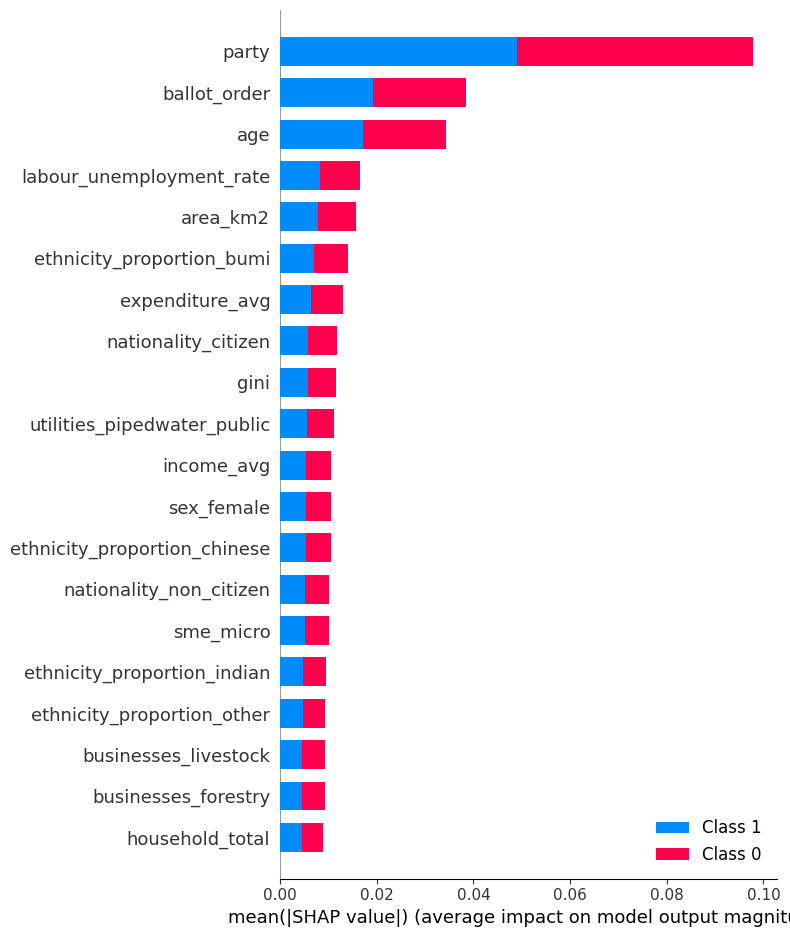

In [87]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

<Axes: title={'center': 'Map of Malaysia'}>

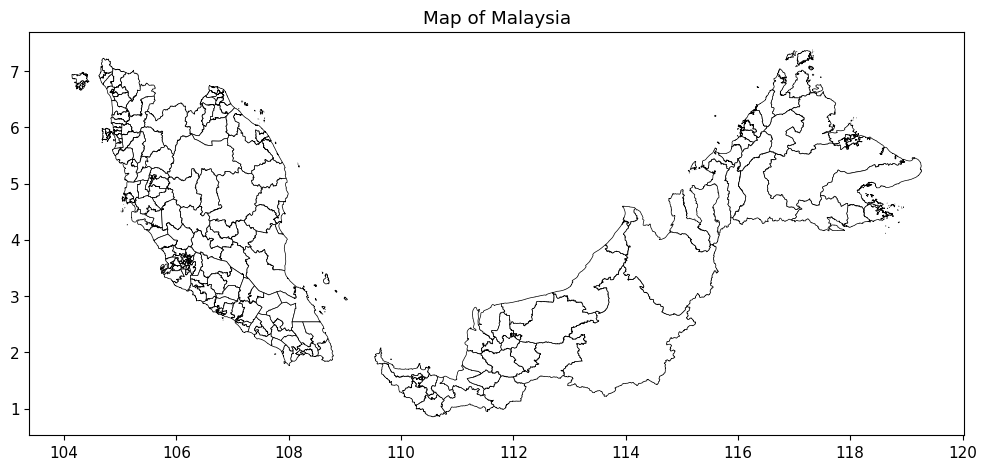

In [27]:
# Filename for the cached data
CACHE_FILENAME = "../Data/parlimen.geojson"

MAPSIZE = [10, 5]

# Read the GeoJSON data from the cache
geo = gpd.read_file(CACHE_FILENAME)

# Uncomment below to maintain a rectangular map, but remove the whitespace caused by the South China Sea
geo.loc[~geo.code_state.isin([12, 13, 15]), "geometry"] = geo.geometry.translate(
    4.5, 0.5
)

# Uncomment below to change from rectangular --> square, for a more compact visual
# geo.loc[~geo.code_state.isin([12, 13, 15]), 'geometry'] = geo.geometry.translate(9, 4.5)
# MAPSIZE = [7,7]

plt.rcParams.update(
    {
        "font.size": 11,
        "font.family": "sans-serif",
        "figure.figsize": MAPSIZE,
        "figure.autolayout": True,
    }
)

fig, ax = plt.subplots()


ax.set_title("Map of Malaysia")
geo.plot(facecolor="#ffffff", linewidth=0.5, edgecolor="black", ax=ax)

In [21]:
geo["district"].nunique()

160